# CSET Policy Analytics

Top 5 analyses for AI incident policy and decision making.


In [73]:
from pathlib import Path
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='talk')
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

In [74]:
raw = {"classifications_CSETv1": pd.read_csv(Path("dataset/classifications_CSETv1.csv"), low_memory=False)}

In [75]:
def normalize_col(col: str) -> str:
    return re.sub(r'_+', '_', re.sub(r'[^a-z0-9]+', '_', col.lower())).strip('_')

def deduplicate_columns(cols: list) -> list:
    seen = {}
    result = []
    for c in cols:
        if c in seen:
            seen[c] += 1
            result.append(f"{c}_{seen[c]}")
        else:
            seen[c] = 0
            result.append(c)
    return result

def top_counts(df, col, n=10):
    if col not in df.columns:
        return pd.DataFrame(columns=[col, 'count'])
    vc = df[col].fillna('missing').astype(str).str.strip().value_counts().head(n).reset_index()
    vc.columns = [col, 'count']
    return vc

def parse_yes_no_maybe(s: pd.Series) -> pd.Series:
    mapper = {
        'yes': 'yes', 'no': 'no', 'maybe': 'maybe',
        'true': 'yes', 'false': 'no',
        'y': 'yes', 'n': 'no'
    }
    x = s.astype(str).str.strip().str.lower()
    out = x.map(mapper)
    # keep original where mapping fails
    return out.where(out.notna(), x.replace('nan', np.nan))

In [76]:
df = raw["classifications_CSETv1"].copy()
normed = [normalize_col(c) for c in df.columns]
df.columns = deduplicate_columns(normed)

In [77]:
# Preprocessing
clean = df.copy()

# Strip whitespace from all object columns
obj_cols = clean.select_dtypes(include='object').columns
for c in obj_cols:
    clean[c] = clean[c].astype(str).str.strip().replace({'': np.nan, 'nan': np.nan})

# Standardize core tri-state / boolean-like columns when present
tri_cols = [
    'published', 'quality_control', 'physical_objects', 'entertainment_industry',
    'report_test_or_study_of_data', 'deployed', 'producer_test_in_controlled_conditions',
    'producer_test_in_operational_conditions', 'user_test_in_controlled_conditions',
    'user_test_in_operational_conditions', 'harm_domain', 'ai_system',
    'clear_link_to_technology', 'clear_link_to_technology_1', 'impact_on_critical_services', 'rights_violation',
    'involving_minor', 'detrimental_content', 'protected_characteristic',
    'special_interest_intangible_harm', 'public_sector_deployment',
    'multiple_ai_interaction', 'embedded', 'estimated_date', 'estimated_harm_quantities'
]
for c in tri_cols:
    if c in clean.columns:
        clean[c] = parse_yes_no_maybe(clean[c])

# Numeric conversion where meaningful
for c in ['incident_id', 'incident_number', 'date_of_incident_year', 'date_of_incident_day', 'lives_lost', 'injuries']:
    if c in clean.columns:
        clean[c] = pd.to_numeric(clean[c], errors='coerce')

# Month normalization
if 'date_of_incident_month' in clean.columns:
    month_map = {
        'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
        'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
    }
    m = clean['date_of_incident_month'].astype(str).str.lower().str.strip()
    clean['date_of_incident_month_num'] = pd.to_numeric(m, errors='coerce').fillna(m.map(month_map))

# Construct estimated date for trend analytics
if {'date_of_incident_year', 'date_of_incident_month_num', 'date_of_incident_day'}.issubset(clean.columns):
    clean['incident_date_estimated'] = pd.to_datetime(
        dict(
            year=clean['date_of_incident_year'],
            month=clean['date_of_incident_month_num'].fillna(1),
            day=clean['date_of_incident_day'].fillna(1)
        ),
        errors='coerce'
    )

clean = clean.drop_duplicates().reset_index(drop=True)

In [78]:
## Top 5 Policy-Relevant Analyses

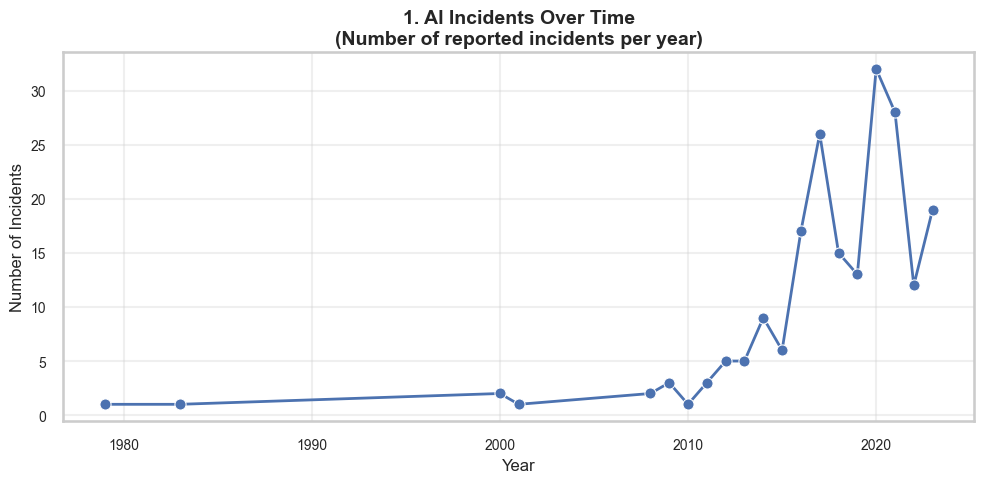

In [79]:
# 1. Incident trend over years
if 'date_of_incident_year' in clean.columns:
    yr = clean['date_of_incident_year'].dropna().astype(int)
    yr_df = yr.value_counts().sort_index().rename_axis('year').reset_index(name='incidents')
    if len(yr_df) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(data=yr_df, x='year', y='incidents', marker='o', linewidth=2, markersize=8, ax=ax)
        ax.set_title('1. AI Incidents Over Time\n(Number of reported incidents per year)', fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Incidents')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print('No year data available.')

## Analytics and Visualizations

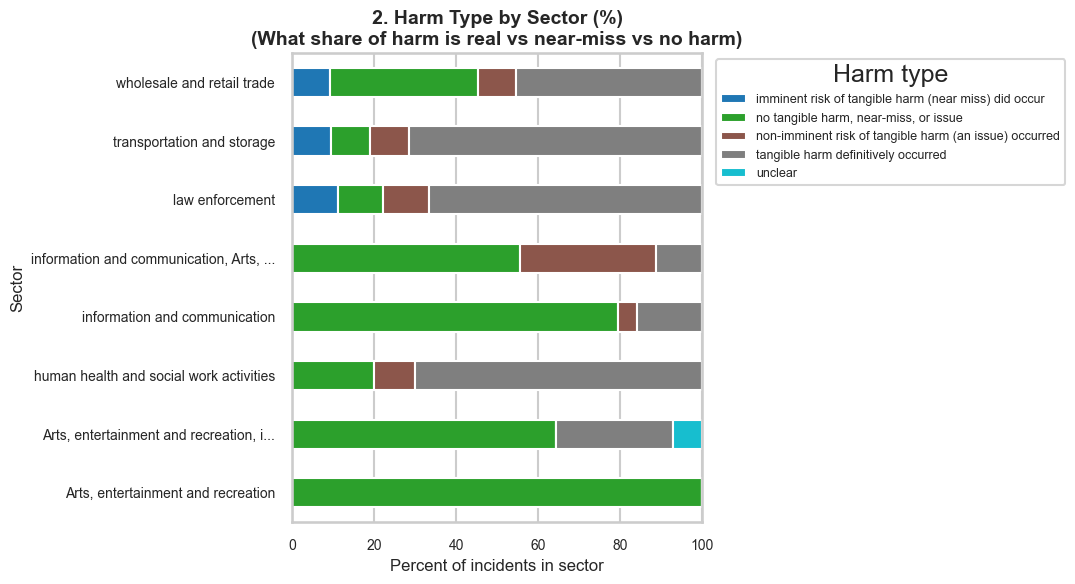

In [80]:
# 2. Tangible harm by sector
if {'tangible_harm', 'sector_of_deployment'}.issubset(clean.columns):
    tmp = clean[['tangible_harm', 'sector_of_deployment']].dropna()
    tmp = tmp[tmp['tangible_harm'].astype(str).str.len() > 2]
    if len(tmp) > 0:
        top_sectors = tmp['sector_of_deployment'].value_counts().head(8).index
        tmp = tmp[tmp['sector_of_deployment'].isin(top_sectors)]
        tmp['sector_short'] = tmp['sector_of_deployment'].apply(lambda x: (str(x)[:37]+'...') if len(str(x))>40 else str(x))
        ct = pd.crosstab(tmp['sector_short'], tmp['tangible_harm'])
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
        fig, ax = plt.subplots(figsize=(11, 6))
        ct_pct.plot(kind='barh', stacked=True, ax=ax, colormap='tab10')
        ax.set_title('2. Harm Type by Sector (%)\n(What share of harm is real vs near-miss vs no harm)', fontweight='bold')
        ax.set_xlabel('Percent of incidents in sector')
        ax.set_ylabel('Sector')
        ax.legend(title='Harm type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print('No sector/harm data available.')


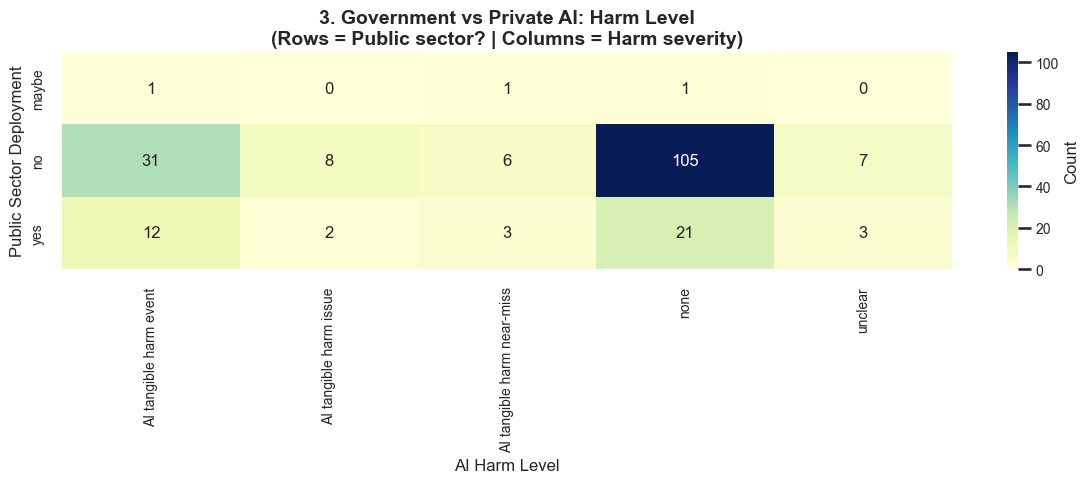

In [81]:
# 3. Public sector vs harm level
if {'public_sector_deployment', 'ai_harm_level'}.issubset(clean.columns):
    ct = pd.crosstab(clean['public_sector_deployment'], clean['ai_harm_level'])
    if ct.size > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu', ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('3. Government vs Private AI: Harm Level\n(Rows = Public sector? | Columns = Harm severity)', fontweight='bold')
        ax.set_xlabel('AI Harm Level')
        ax.set_ylabel('Public Sector Deployment')
        plt.tight_layout()
        plt.show()
    else:
        print('No public sector / harm level data.')


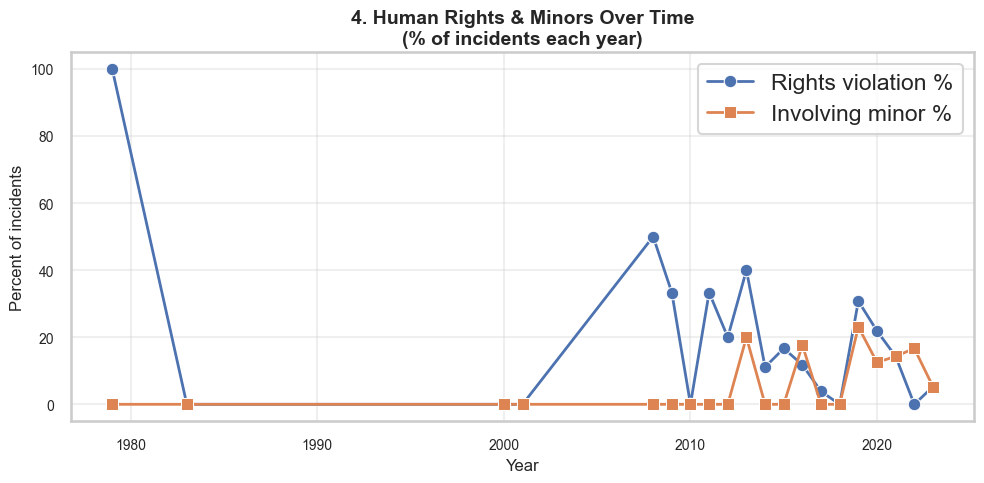

In [82]:
# 4. Rights violation & minors over time
if {'date_of_incident_year', 'rights_violation', 'involving_minor'}.issubset(clean.columns):
    tmp = clean[['date_of_incident_year', 'rights_violation', 'involving_minor']].copy()
    tmp['year'] = pd.to_numeric(tmp['date_of_incident_year'], errors='coerce')
    tmp = tmp.dropna(subset=['year'])
    agg = tmp.groupby('year', as_index=False).agg(
        rights_pct=('rights_violation', lambda x: (x == 'yes').mean() * 100),
        minor_pct=('involving_minor', lambda x: (x == 'yes').mean() * 100)
    )
    if len(agg) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.lineplot(data=agg, x='year', y='rights_pct', marker='o', linewidth=2, label='Rights violation %', ax=ax)
        sns.lineplot(data=agg, x='year', y='minor_pct', marker='s', linewidth=2, label='Involving minor %', ax=ax)
        ax.set_title('4. Human Rights & Minors Over Time\n(% of incidents each year)', fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Percent of incidents')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print('No year/rights/minor data.')


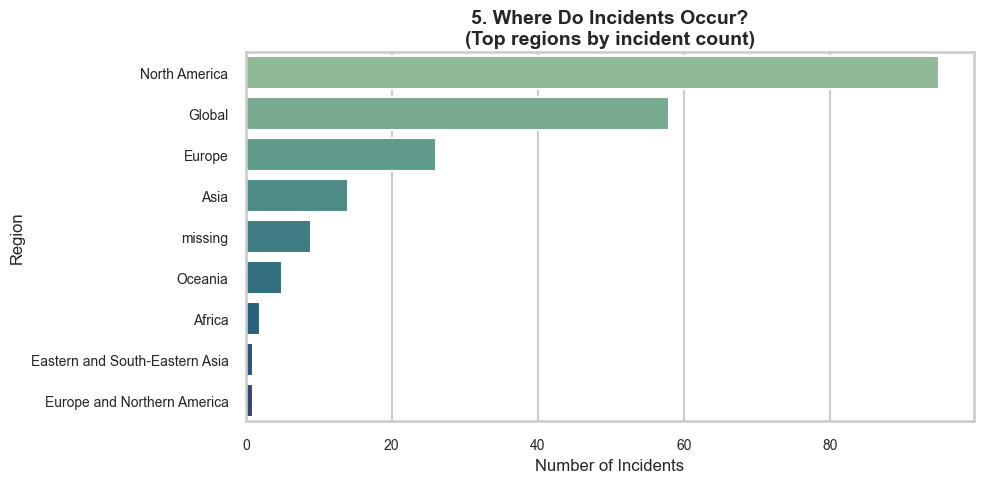

In [83]:
# 5. Geographic concentration
if 'location_region' in clean.columns:
    t = top_counts(clean, 'location_region', n=10)
    t = t[t['location_region'].astype(str).str.len() > 2]
    if len(t) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.barplot(data=t, y='location_region', x='count', palette='crest', ax=ax)
        ax.set_title('5. Where Do Incidents Occur?\n(Top regions by incident count)', fontweight='bold')
        ax.set_xlabel('Number of Incidents')
        ax.set_ylabel('Region')
        plt.tight_layout()
        plt.show()
    else:
        print('No region data.')


## Additional Policy Analyses

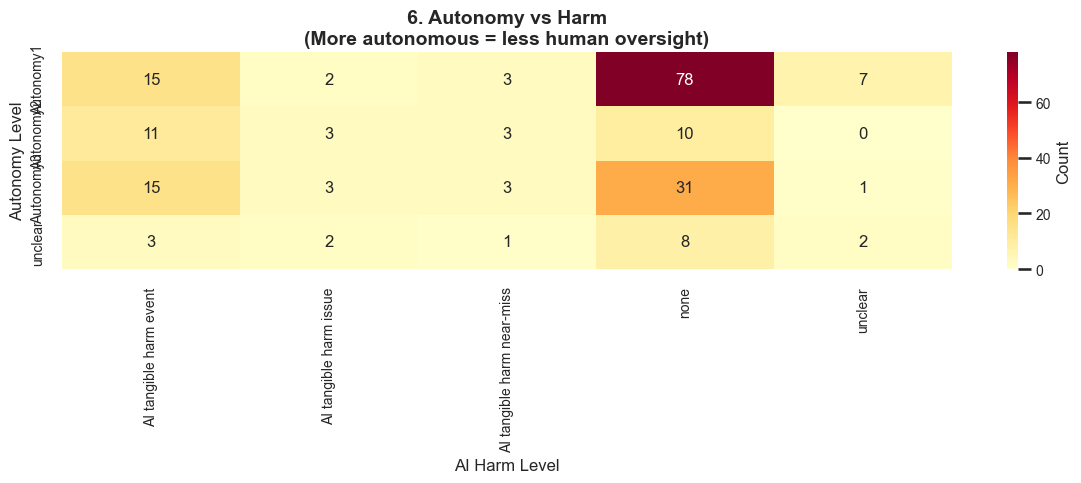

In [84]:
# 6. Autonomy level vs harm severity
if {'autonomy_level', 'ai_harm_level'}.issubset(clean.columns):
    ct = pd.crosstab(clean['autonomy_level'], clean['ai_harm_level'])
    if ct.size > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('6. Autonomy vs Harm\n(More autonomous = less human oversight)', fontweight='bold')
        ax.set_xlabel('AI Harm Level')
        ax.set_ylabel('Autonomy Level')
        plt.tight_layout()
        plt.show()
    else:
        print('No autonomy/harm data.')

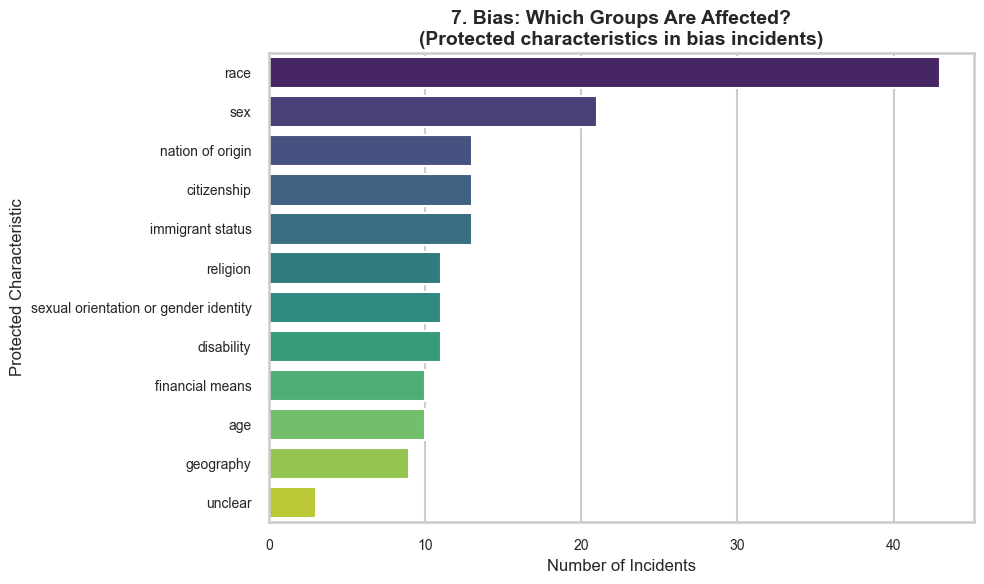

In [85]:
# 7. Protected characteristics and bias (uses Harm Distribution Basis for characteristic names)
if 'harm_distribution_basis' in clean.columns:
    t = clean['harm_distribution_basis'].dropna().astype(str).str.strip()
    t = t[~t.str.lower().isin(['yes', 'no', 'maybe', 'none', ''])]
    t = t[t.str.len() > 2]
    if len(t) > 0:
        bias_vals = t.str.split(',').explode().str.strip()
        bias_vals = bias_vals[(bias_vals.str.len() > 2) & (bias_vals != '')]
        vc = bias_vals.value_counts().head(12).reset_index()
        vc.columns = ['characteristic', 'count']
        if len(vc) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            sns.barplot(data=vc, y='characteristic', x='count', palette='viridis', ax=ax)
            ax.set_title('7. Bias: Which Groups Are Affected?\n(Protected characteristics in bias incidents)', fontweight='bold')
            ax.set_xlabel('Number of Incidents')
            ax.set_ylabel('Protected Characteristic')
            plt.tight_layout()
            plt.show()
        else:
            print('No characteristic data.')
    else:
        print('No characteristic data.')

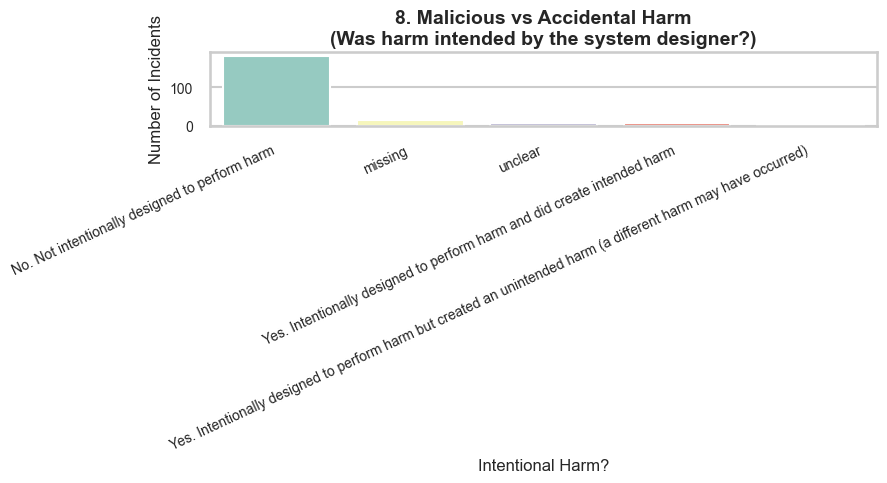

In [86]:
# 8. Intentional vs unintentional harm
if 'intentional_harm' in clean.columns:
    t = top_counts(clean, 'intentional_harm', n=8)
    t = t[t['intentional_harm'].astype(str).str.len() > 2]
    if len(t) > 0:
        fig, ax = plt.subplots(figsize=(9, 5))
        sns.barplot(data=t, x='intentional_harm', y='count', palette='Set3', ax=ax)
        ax.set_title('8. Malicious vs Accidental Harm\n(Was harm intended by the system designer?)', fontweight='bold')
        ax.set_xlabel('Intentional Harm?')
        ax.set_ylabel('Number of Incidents')
        plt.xticks(rotation=25, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print('No intentional harm data.')

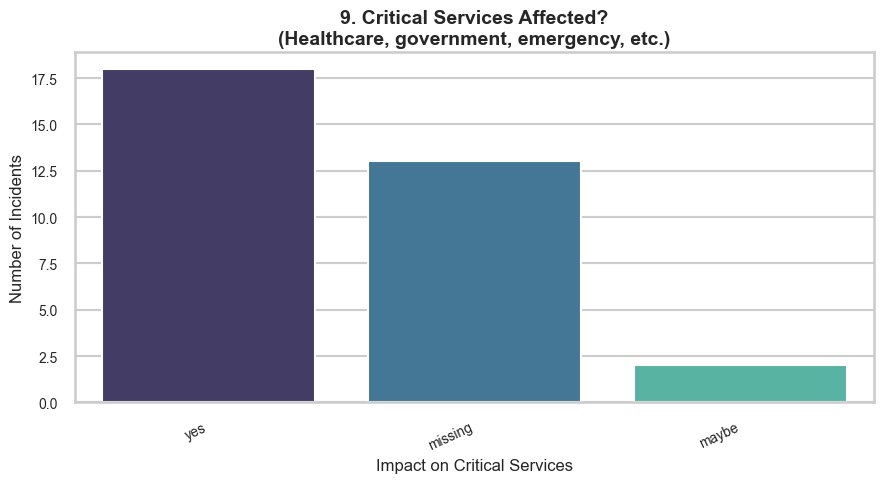

In [87]:
# 9. Impact on critical services
if 'impact_on_critical_services' in clean.columns:
    t = top_counts(clean, 'impact_on_critical_services', n=8)
    t = t[t['impact_on_critical_services'].astype(str).str.len() > 2]
    if len(t) > 0:
        fig, ax = plt.subplots(figsize=(9, 5))
        sns.barplot(data=t, x='impact_on_critical_services', y='count', palette='mako', ax=ax)
        ax.set_title('9. Critical Services Affected?\n(Healthcare, government, emergency, etc.)', fontweight='bold')
        ax.set_xlabel('Impact on Critical Services')
        ax.set_ylabel('Number of Incidents')
        plt.xticks(rotation=25, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print('No critical services data.')

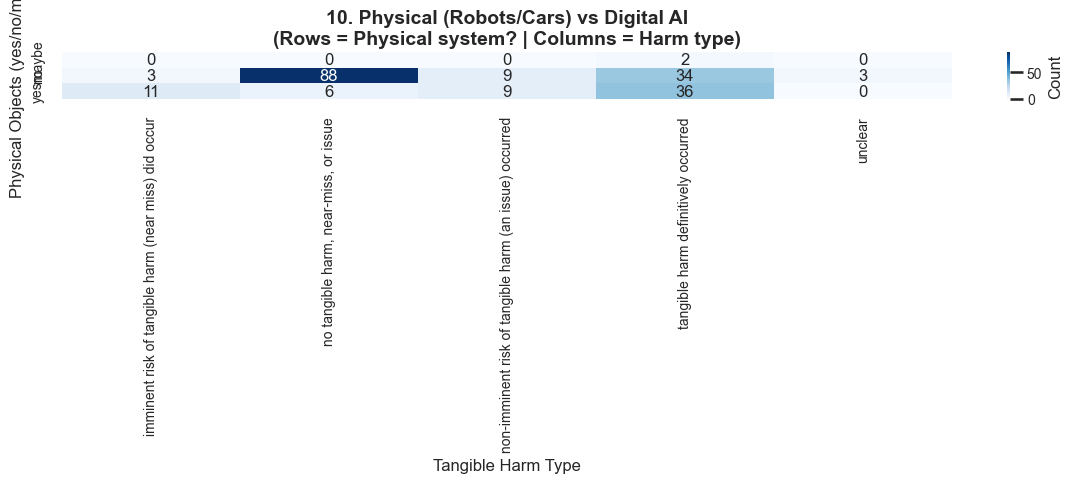

In [88]:
# 10. Physical vs digital harm
if {'physical_objects', 'tangible_harm'}.issubset(clean.columns):
    ct = pd.crosstab(clean['physical_objects'], clean['tangible_harm'])
    if ct.size > 0:
        fig, ax = plt.subplots(figsize=(12, 5))
        sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
        ax.set_title('10. Physical (Robots/Cars) vs Digital AI\n(Rows = Physical system? | Columns = Harm type)', fontweight='bold')
        ax.set_xlabel('Tangible Harm Type')
        ax.set_ylabel('Physical Objects (yes/no/maybe)')
        plt.tight_layout()
        plt.show()
    else:
        print('No physical/tangible harm data.')

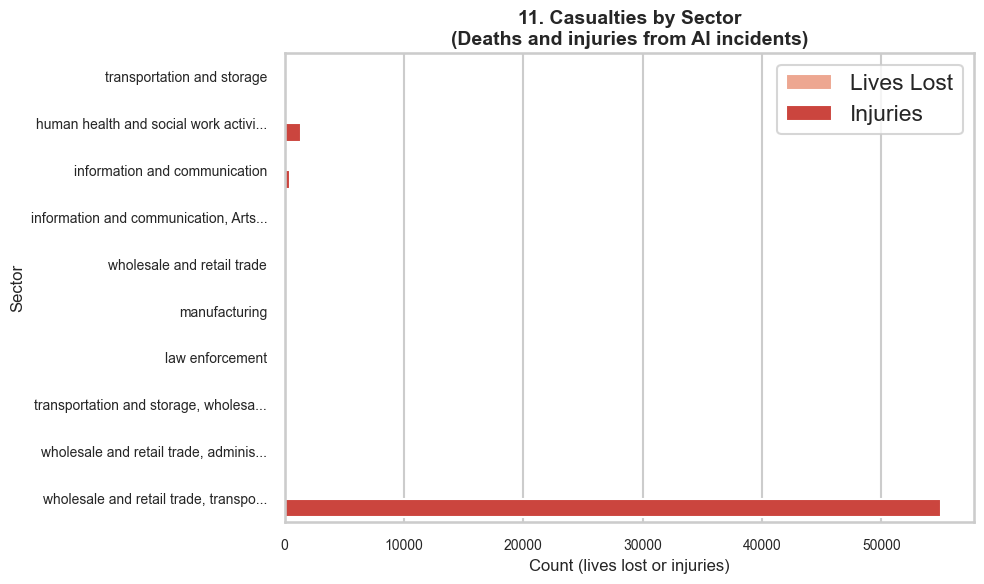

In [89]:
# 11. Lives lost and injuries by sector
if {'sector_of_deployment', 'lives_lost', 'injuries'}.issubset(clean.columns):
    tmp = clean[['sector_of_deployment', 'lives_lost', 'injuries']].copy()
    tmp['lives_lost'] = pd.to_numeric(tmp['lives_lost'], errors='coerce').fillna(0)
    tmp['injuries'] = pd.to_numeric(tmp['injuries'], errors='coerce').fillna(0)
    agg = tmp.groupby('sector_of_deployment').agg({'lives_lost': 'sum', 'injuries': 'sum'}).reset_index()
    agg = agg[(agg['lives_lost'] > 0) | (agg['injuries'] > 0)].sort_values('lives_lost', ascending=False).head(10)
    if len(agg) > 0:
        agg_m = agg.melt(id_vars='sector_of_deployment', var_name='metric', value_name='count')
        agg_m['metric'] = agg_m['metric'].replace({'lives_lost': 'Lives Lost', 'injuries': 'Injuries'})
        agg_m['sector_short'] = agg_m['sector_of_deployment'].apply(lambda x: x[:35]+'...' if len(str(x))>38 else x)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(data=agg_m, y='sector_short', x='count', hue='metric', palette='Reds', ax=ax)
        ax.set_title('11. Casualties by Sector\n(Deaths and injuries from AI incidents)', fontweight='bold')
        ax.set_xlabel('Count (lives lost or injuries)')
        ax.set_ylabel('Sector')
        ax.legend(title='')
        plt.tight_layout()
        plt.show()
    else:
        print('No casualty data by sector.')

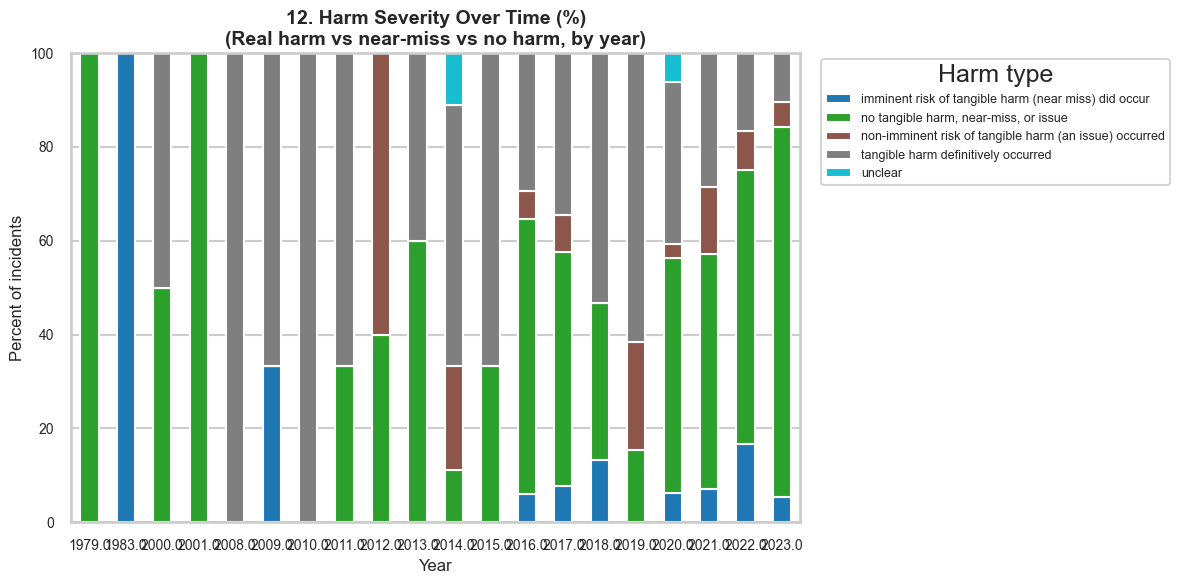

In [90]:
# 12. Harm severity trend over time
if {'date_of_incident_year', 'tangible_harm'}.issubset(clean.columns):
    tmp = clean[['date_of_incident_year', 'tangible_harm']].copy()
    tmp['year'] = pd.to_numeric(tmp['date_of_incident_year'], errors='coerce')
    tmp = tmp.dropna(subset=['year', 'tangible_harm'])
    tmp = tmp[tmp['tangible_harm'].astype(str).str.len() > 2]
    if len(tmp) > 0:
        ct = pd.crosstab(tmp['year'], tmp['tangible_harm'])
        ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
        fig, ax = plt.subplots(figsize=(12, 6))
        ct_pct.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')
        ax.set_title('12. Harm Severity Over Time (%)\n(Real harm vs near-miss vs no harm, by year)', fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Percent of incidents')
        ax.legend(title='Harm type', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print('No year/harm data.')

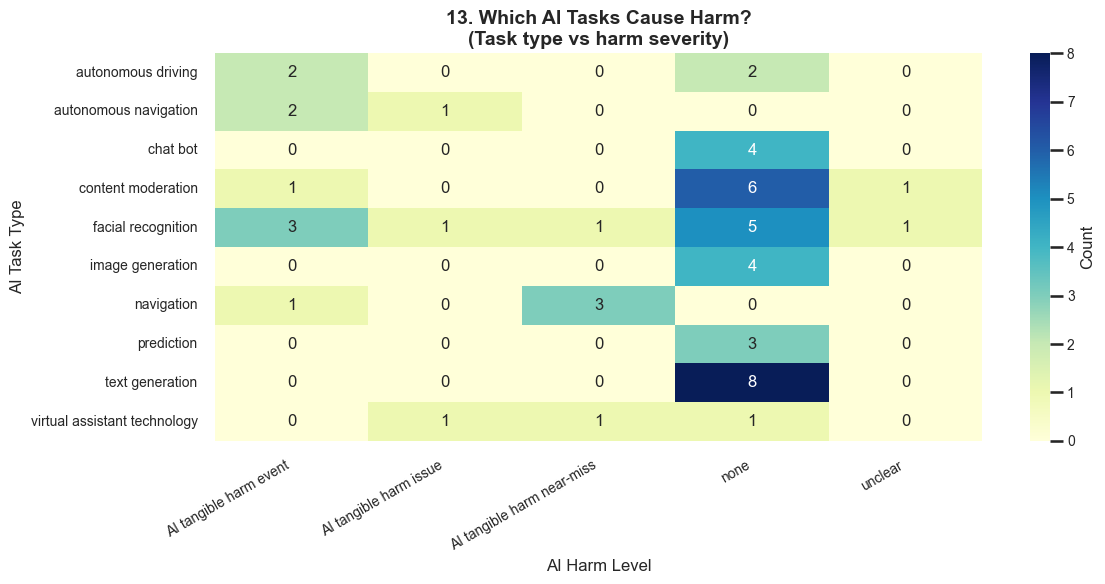

In [91]:
# 13. AI task type and harm
if {'ai_task', 'ai_harm_level'}.issubset(clean.columns):
    tmp = clean[['ai_task', 'ai_harm_level']].dropna()
    tmp['ai_task'] = tmp['ai_task'].astype(str).str.split(',').str[0].str.strip()
    tmp = tmp[tmp['ai_task'].str.len() > 2]
    if len(tmp) > 0:
        top_tasks = tmp['ai_task'].value_counts().head(10).index
        tmp = tmp[tmp['ai_task'].isin(top_tasks)]
        tmp['task_short'] = tmp['ai_task'].apply(lambda x: x[:30]+'...' if len(str(x))>33 else x)
        ct = pd.crosstab(tmp['task_short'], tmp['ai_harm_level'])
        if ct.size > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu', ax=ax, cbar_kws={'label': 'Count'})
            ax.set_title('13. Which AI Tasks Cause Harm?\n(Task type vs harm severity)', fontweight='bold')
            ax.set_xlabel('AI Harm Level')
            ax.set_ylabel('AI Task Type')
            plt.xticks(rotation=30, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print('No AI task/harm data.')
    else:
        print('No AI task data.')

## Export Reproducible Artifacts

In [92]:
Path('outputs').mkdir(exist_ok=True)
clean.to_csv('outputs/csetv1_cleaned.csv', index=False)
print('Saved outputs/csetv1_cleaned.csv')


Saved outputs/csetv1_cleaned.csv
